<font size="6.9">**Varying Methods in a Data Science Process - Predictive Maintenance for Turbines**</font>

**Goal:**  
Demonstration of varying methods used in a data science project. Even though the methods used in this project follow the act of a use case and are therefore sequential, they are a selection only and this is not meant to be a full stack project.  
The following table of content gives an overview for the demonstrated methods.  

**Table of Content: Varying Methods in a Data Science Process**
1. Preprocessing data:
    - 1.1 to 1.3: Data exploration   
    - 1.4: Data cleaning 
    - 1.5 to 1.7: Feature engineering
    - 1.8 Building a pipeline for preprocessing steps


2. Model Building, Tuning & Evaluation:
    - 2.2: KNN classifier (using grid search for hyperparameter optimization)
    - 2.3: SVM classifier (using grid search for hyperparameter optimization)
    - 2.4: NN classifier (using random search for hyperparameter optimization including neural network architecture)
    - 2.5 Model comparison



**Description of the use-case: Predicitive Maintenance for Turbines** 
- the goal is to build a data driven model to predict the time of break down for an aircraft turbine. Subsequently the prediction will be used to schedule the time of maintenance.
- Tasks:  
    1. Get insights and preprocess data
    2. Build, optimize and evaluate a model that predicts the time of breakdown for a turbine


**Dataset description:**  
Turbofan Engine Degradation Simulation Data Set: https://ti.arc.nasa.gov/tech/dash/groups/pcoe/prognostic-data-repository/#turbofan  
Column represents the settings: ['unit', 'cycle', 'setting_1', 'setting_2', 'setting_3', 'sensor_1', 'sensor_2', 'sensor_3', 'sensor_4', 'sensor_5', 'sensor_6', 'sensor_7', 'sensor_8', 'sensor_9', 'sensor_10', 'sensor_11', 'sensor_12', 'sensor_13', 'sensor_14', 'sensor_15', 'sensor_16', 'sensor_17', 'sensor_18', 'sensor_19', 'sensor_20', 'sensor_21']  
Each row represents the record for the settings for one cycle of a single specific turbine  

Column 'unit':  
- represents the engine (total number of engines = 100)
- contain information about the first customer group

Column 'cycle':
- contain the number of cycles for each engine until break down of the engine (veries for each engine)
- a single cycle represents a measurment in time during operation of an engine (flight of an aircraft)

Column 'setting_X':
- won´t be considered in this demonstation

Column 'sensor_X':
- measurement of a single cycle for 21 sensors
- domain knowledge of the sensors won´t be considered in this demonstation

Target – degradation of the engine as numerical:
- represents the degradation of engine until break down
- will be transformed into categorical (predefined cycle cluster). Meaning of categories (cycle clusters):
    - 1 (longterm): less than 14 cycles left to break down
    - 2 (midterm): 14 to 70 cycles left to break down
    - 3 (urgent): more than 70 cycles left to break down

# 1. Preprocessing Data

Demonstration of a selection of methods used for data pre-processing

In [1]:
# Importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## 1.1 Load data

Test-/Validation-Split: load dataset and hold out validation dataset for later steps (e.g. evaluation)

In [2]:
# import dataset
dataset = pd.read_csv('CMAPSSData/train_FD001.txt', header=None, sep=' ')

In [3]:
# set header names
a_header = ['unit', 'cycle', 'setting_1', 'setting_2', 'setting_3', 'sensor_1', 'sensor_2', 'sensor_3', 'sensor_4', 'sensor_5', 'sensor_6', 'sensor_7', 'sensor_8', 'sensor_9', 'sensor_10', 'sensor_11', 'sensor_12', 'sensor_13', 'sensor_14', 'sensor_15', 'sensor_16', 'sensor_17', 'sensor_18', 'sensor_19', 'sensor_20', 'sensor_21', 'H27', 'H28']
dataset.columns = a_header

In [4]:
dataset.head(5)

,unit,cycle,setting_1,setting_2,setting_3,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,...,sensor_14,sensor_15,sensor_16,sensor_17,sensor_18,sensor_19,sensor_20,sensor_21,H27,H28
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,NaN,NaN
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,NaN,NaN
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,NaN,NaN
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,NaN,NaN
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,NaN,NaN


In [5]:
#delete unwanted columns 26 and 27
dataset = dataset.drop(['H27', 'H28'], axis=1)

## 1.2 Get basic information of the dataset

In [6]:
dataset.describe()

,unit,cycle,setting_1,setting_2,setting_3,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,...,sensor_12,sensor_13,sensor_14,sensor_15,sensor_16,sensor_17,sensor_18,sensor_19,sensor_20,sensor_21
count,20631.000000,20631.000000,20631.000000,20631.000000,20631.0,20631.00,20631.000000,20631.000000,20631.000000,2.063100e+04,...,20631.000000,20631.000000,20631.000000,20631.000000,2.063100e+04,20631.000000,20631.0,20631.0,20631.000000,20631.000000
mean,51.506568,108.807862,-0.000009,0.000002,100.0,518.67,642.680934,1590.523119,1408.933782,1.462000e+01,...,521.413470,2388.096152,8143.752722,8.442146,3.000000e-02,393.210654,2388.0,100.0,38.816271,23.289705
std,29.227633,68.880990,0.002187,0.000293,0.0,0.00,0.500053,6.131150,9.000605,1.776400e-15,...,0.737553,0.071919,19.076176,0.037505,1.387812e-17,1.548763,0.0,0.0,0.180746,0.108251
min,1.000000,1.000000,-0.008700,-0.000600,100.0,518.67,641.210000,1571.040000,1382.250000,1.462000e+01,...,518.690000,2387.880000,8099.940000,8.324900,3.000000e-02,388.000000,2388.0,100.0,38.140000,22.894200
25%,26.000000,52.000000,-0.001500,-0.000200,100.0,518.67,642.325000,1586.260000,1402.360000,1.462000e+01,...,520.960000,2388.040000,8133.245000,8.414900,3.000000e-02,392.000000,2388.0,100.0,38.700000,23.221800
50%,52.000000,104.000000,0.000000,0.000000,100.0,518.67,642.640000,1590.100000,1408.040000,1.462000e+01,...,521.480000,2388.090000,8140.540000,8.438900,3.000000e-02,393.000000,2388.0,100.0,38.830000,23.297900
75%,77.000000,156.000000,0.001500,0.000300,100.0,518.67,643.000000,1594.380000,1414.555000,1.462000e+01,...,521.950000,2388.140000,8148.310000,8.465600,3.000000e-02,394.000000,2388.0,100.0,38.950000,23.366800
max,100.000000,362.000000,0.008700,0.000600,100.0,518.67,644.530000,1616.910000,1441.490000,1.462000e+01,...,523.380000,2388.560000,8293.720000,8.584800,3.000000e-02,400.000000,2388.0,100.0,39.430000,23.618400


In [7]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20631 entries, 0 to 20630
Data columns (total 26 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   unit       20631 non-null  int64  
 1   cycle      20631 non-null  int64  
 2   setting_1  20631 non-null  float64
 3   setting_2  20631 non-null  float64
 4   setting_3  20631 non-null  float64
 5   sensor_1   20631 non-null  float64
 6   sensor_2   20631 non-null  float64
 7   sensor_3   20631 non-null  float64
 8   sensor_4   20631 non-null  float64
 9   sensor_5   20631 non-null  float64
 10  sensor_6   20631 non-null  float64
 11  sensor_7   20631 non-null  float64
 12  sensor_8   20631 non-null  float64
 13  sensor_9   20631 non-null  float64
 14  sensor_10  20631 non-null  float64
 15  sensor_11  20631 non-null  float64
 16  sensor_12  20631 non-null  float64
 17  sensor_13  20631 non-null  float64
 18  sensor_14  20631 non-null  float64
 19  sensor_15  20631 non-null  float64
 20  sensor

## 1.3 Further Data Exploration

Get some basic understanding of the data by using descriptive and visual analytics

### 1.3.1 Features & Distribution of Features

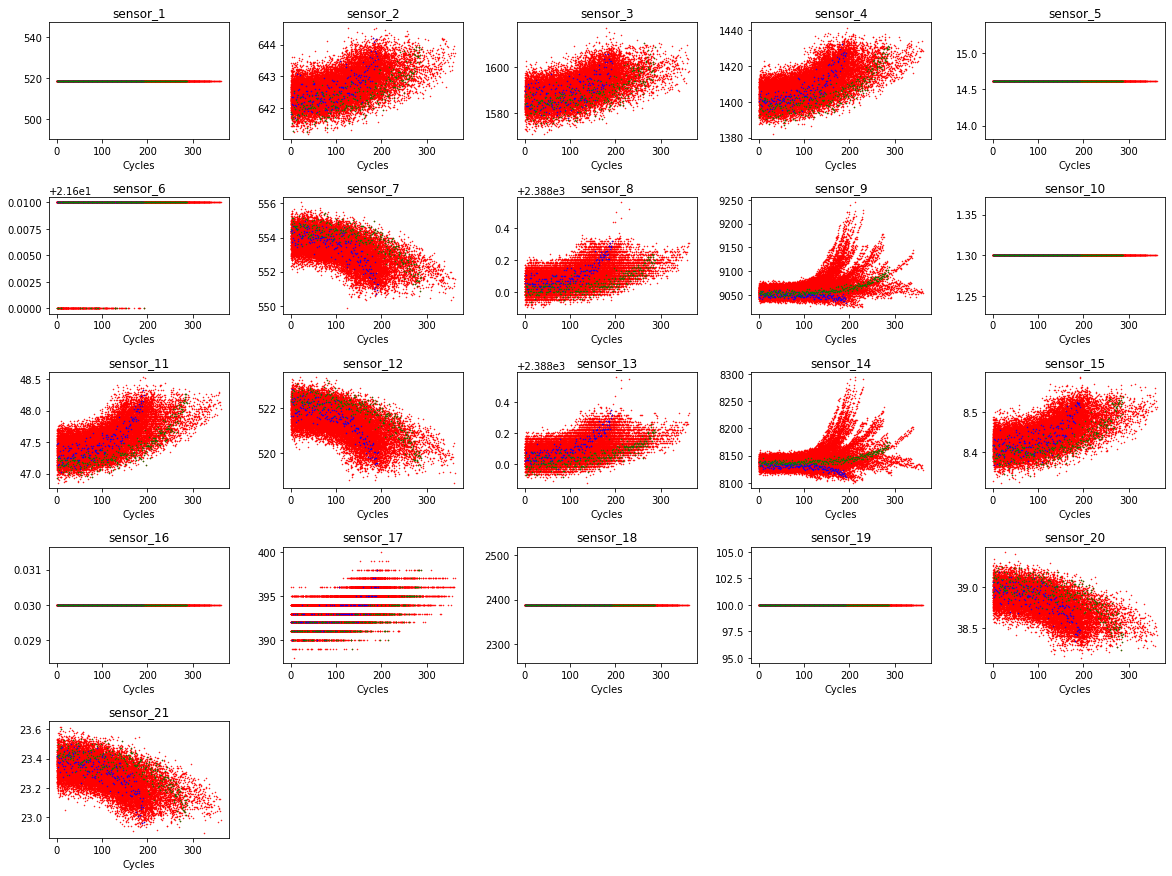

In [8]:
# plot all sensors for all 100 engines and highlight the 1. and 2. engine
# dataset for 1. engine
dataset_e1 = dataset.loc[dataset['unit'] == 1]
# dataset for 2. engine
dataset_e2 = dataset.loc[dataset['unit'] == 2]
plt.figure(figsize=(20, 15)) #absolut for the whole figure
for i in range(21):
    i+=1 # start with plot 1
    plt.subplot(5,5,i) # evenly distributed over the whole figure
    plt.subplots_adjust(wspace=0.3, hspace=0.5) # relative distances
    plt.title('sensor_'+str(i))
    plt.xlabel('Cycles')
    plt.plot(dataset.cycle, dataset['sensor_'+str(i)], '.', color='red', markersize=1)
    plt.plot(dataset_e1.cycle, dataset_e1['sensor_'+str(i)], '.', color='blue', markersize=1)
    plt.plot(dataset_e2.cycle, dataset_e2['sensor_'+str(i)], '.', color='green', markersize=1)

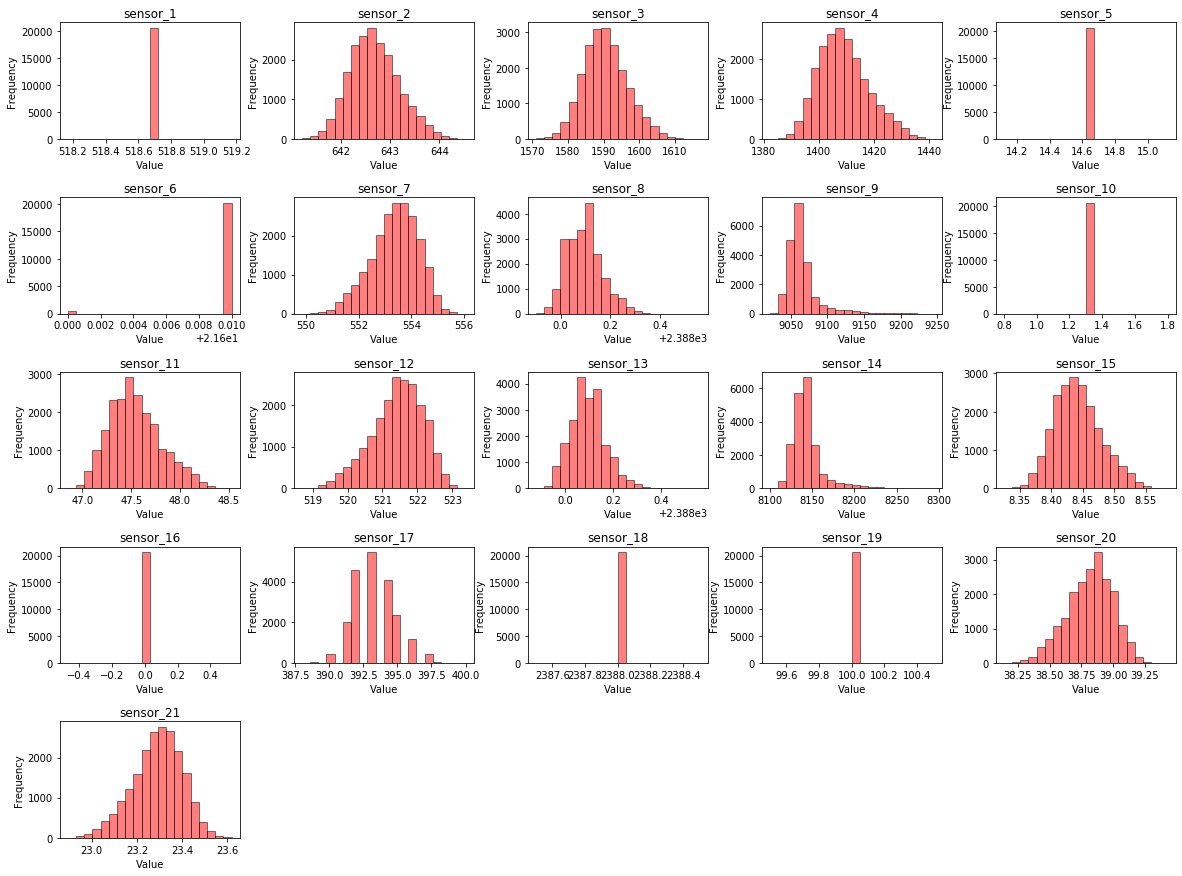

In [9]:
# plot distribution of all sensors
plt.figure(figsize=(20, 15)) #absolut for the whole figure
for i in range(21):
    i+=1 # start with plot 1
    # define subplot (n_rows, n_colums, plot_number)
    plt.subplot(5,5,i) # evenly distributed over the whole figure
    plt.subplots_adjust(wspace=0.3, hspace=0.5) # relative distances
    plt.hist(dataset['sensor_'+str(i)], color='red', alpha=0.5, ec='black', bins=20)
    plt.title('sensor_'+str(i))
    plt.xlabel("Value")
    plt.ylabel("Frequency")

## 1.4 Data Cleaning

Depending on the problem and data different cleaning steps have to be considered, like:
- Handeling missing values
- Resolving data inconsistencies
- Smoothing noisy data
- Handling/removing outliers

Since the goal is to find and predict the time of failure let´s get a better understanding of outliers

### 1.4.1 Missing Values

In [10]:
# Check if any data is missing
dataset.isnull().values.any()

False

### 1.4.2 Outlier detection - Tukey IQR

getting a better understanding of outliers, since the goal is to find and predict the time of failure

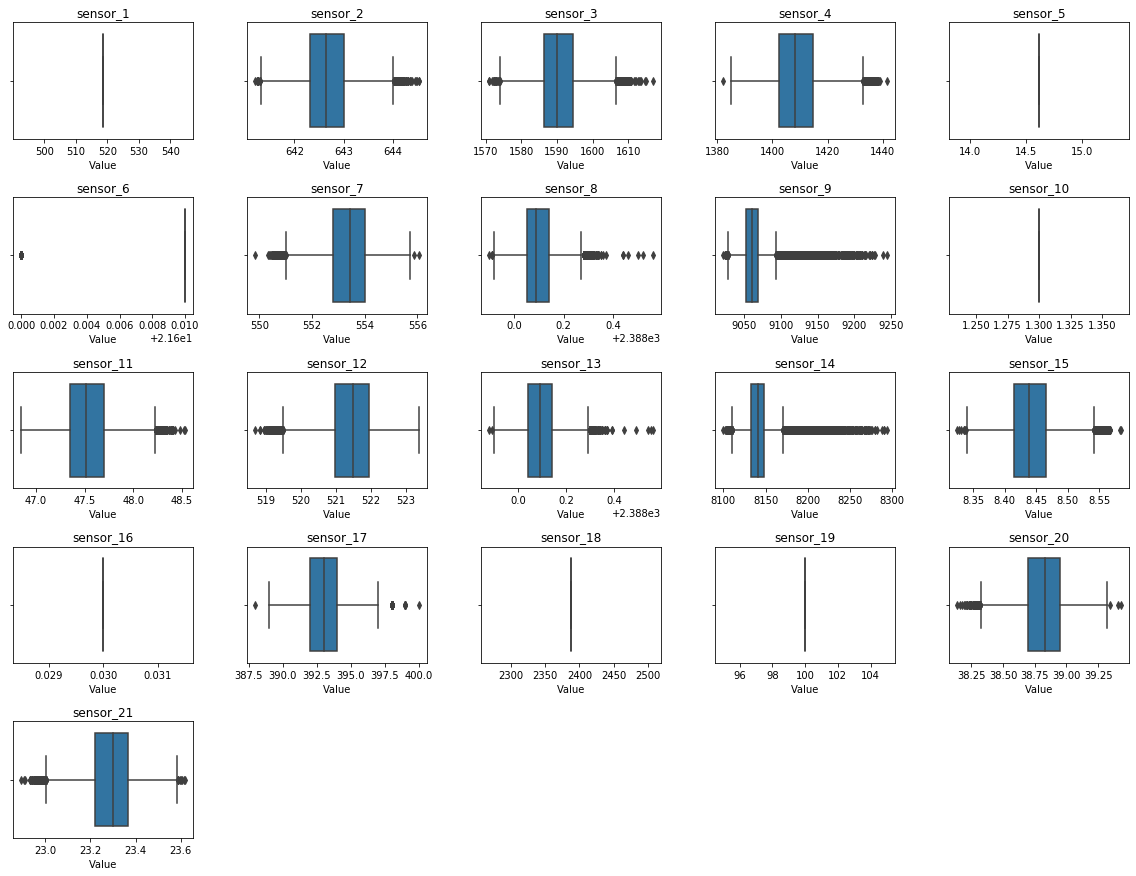

In [11]:
# Visualize IQR outliers with IQR Box Plots
import seaborn as sns

plt.figure(figsize=(20, 15)) #absolut for the whole figure
for i in range(21):
    i+=1 # start with plot 1
    # define subplot (n_rows, n_colums, plot_number)
    plt.subplot(5,5,i) # evenly distributed over the whole figure
    plt.subplots_adjust(wspace=0.3, hspace=0.5) # relative distances
    sns.boxplot(x=dataset['sensor_'+str(i)], data=dataset)
    plt.title('sensor_'+str(i))
    plt.xlabel("Value")

In [12]:
# function to detect outliers - tukey IQR
def find_outliers_tukey(x):
    """
    Detects outliers (below Q1-1.5(Q3-Q1) or above Q3+1.5(Q3-Q1)) for a single feature
    
    returns outlier_indices, outlier_values
    

    Arguments
    ---------
    x:  pandas series of a single feature  

    """
    q1 = np.percentile(x, 25)
    q3 = np.percentile(x, 75)
    iqr = q3-q1 
    floor = q1 - 1.5*iqr
    ceiling = q3 + 1.5*iqr
    outlier_indices = list(x.index[(x < floor)|(x > ceiling)])
    outlier_values = list(x[outlier_indices])

    return outlier_indices, outlier_values

Text(0.5, 0, 'Sensor')

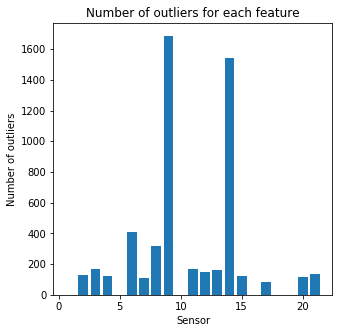

In [13]:
# Outlier detection for the whole dataset -> total amount and destribution of outliers over the different features

# create np.array for number of outliers for each variable
num_outliers_per_feature = []
# iterate over features in dataframe
for i in range(21):
    i+=1 # start with plot 1
    tukey_indices, tukey_values = find_outliers_tukey(dataset['sensor_'+str(i)])
    num_outliers_per_feature.append(len(tukey_indices))
    
# plotdistribution of all sensors
plt.figure(figsize=(5, 5)) # absolut for the whole figure
# x labels for plot
x = np.arange(1, 22)
plt.bar(x, num_outliers_per_feature)
plt.title('Number of outliers for each feature')
plt.ylabel("Number of outliers")
plt.xlabel("Sensor")

## 1.5 Feature Selection

Analyse features to conduct feature selection.  
- less complex models tend to have better generalization and less training time
- remove redundant information
- remove features with no or less information

### 1.5.1 Prepare dataset

#### 1.5.1.1 Seperate features from the dataset

In [14]:
# load sensor data only, without unit, cycle and settings
features = dataset.drop(['unit', 'cycle', 'setting_1', 'setting_2', 'setting_3'], axis=1)
features = features.values
b_header = ['sensor_1', 'sensor_2', 'sensor_3', 'sensor_4', 'sensor_5', 'sensor_6', 'sensor_7', 'sensor_8', 'sensor_9', 'sensor_10', 'sensor_11', 'sensor_12', 'sensor_13', 'sensor_14', 'sensor_15', 'sensor_16', 'sensor_17', 'sensor_18', 'sensor_19', 'sensor_20', 'sensor_21']
df_all_features = pd.DataFrame(features, columns=b_header)

In [15]:
df_all_features.head()

,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,sensor_6,sensor_7,sensor_8,sensor_9,sensor_10,...,sensor_12,sensor_13,sensor_14,sensor_15,sensor_16,sensor_17,sensor_18,sensor_19,sensor_20,sensor_21
0,518.67,641.82,1589.70,1400.60,14.62,21.61,554.36,2388.06,9046.19,1.3,...,521.66,2388.02,8138.62,8.4195,0.03,392.0,2388.0,100.0,39.06,23.4190
1,518.67,642.15,1591.82,1403.14,14.62,21.61,553.75,2388.04,9044.07,1.3,...,522.28,2388.07,8131.49,8.4318,0.03,392.0,2388.0,100.0,39.00,23.4236
2,518.67,642.35,1587.99,1404.20,14.62,21.61,554.26,2388.08,9052.94,1.3,...,522.42,2388.03,8133.23,8.4178,0.03,390.0,2388.0,100.0,38.95,23.3442
3,518.67,642.35,1582.79,1401.87,14.62,21.61,554.45,2388.11,9049.48,1.3,...,522.86,2388.08,8133.83,8.3682,0.03,392.0,2388.0,100.0,38.88,23.3739
4,518.67,642.37,1582.85,1406.22,14.62,21.61,554.00,2388.06,9055.15,1.3,...,522.19,2388.04,8133.80,8.4294,0.03,393.0,2388.0,100.0,38.90,23.4044


#### 1.5.1.2 Create target variable with remaining cycles to failure for each engine

In [16]:
# DataFrame for remaining_cycles_to_failure
a_flip_total = np.zeros(0)
for j in range(100):
    j+=1
    amount_of_cycles_to_failure = dataset.loc[dataset['unit'] == j].unit.shape #shape of the dataset for each engine
    amount_of_cycles_to_failure = amount_of_cycles_to_failure[0] # amount of cycles for each engine to failure
    a_flip = np.flip(np.arange(1,amount_of_cycles_to_failure+1)) # flip array for "remaining cycle to failure"
    a_flip_total = np.append(a_flip_total, a_flip) # add value for the next engine
df_cycles_to_failure = pd.DataFrame(a_flip_total, columns=['cycles_to_failure'])
df_ctf = df_cycles_to_failure

#### 1.5.1.3 Create target variable with predefined cycle cluster

In [17]:
# Prepair Data for Classification

# create labels (urgent, midterm and longterm) for test-dataset
urgent = 14 # less than 14 cycles left to failure
midterm = 70 # less than 70 cycles left to failure
longterm = 70 # more than 70 cycles left to failure
a_label = np.zeros(0)
for i, row in df_ctf.iterrows():
    if row['cycles_to_failure'] > longterm:
        label = 1 # longterm
    if row['cycles_to_failure'] <= midterm:
        label = 2 # midterm
    if row['cycles_to_failure'] < urgent:
        label = 3 # urgent
    a_label = np.append(a_label, label)
label = pd.DataFrame(a_label, columns=['target'])
if 'target' in df_ctf:
        df_ctf = df_ctf.drop('target', axis=1)
df_ctf = df_ctf.join(label['target'], how='right')

# df with target
target_clf = df_ctf['target']

Text(0.5, 0, 'Classes')

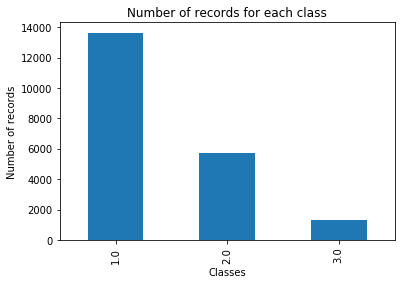

In [18]:
# Visualize the number of records for the 3 classes
cluster_counts = target_clf.value_counts()
cluster_counts.plot(kind='bar')
plt.title('Number of records for each class')
plt.ylabel("Number of records")
plt.xlabel("Classes")

### 1.5.2 Standardize Data

- standardization of the data is needed to do proper feature analysis using statistical test
- standardization of data is needed because some machine learning models are fundamentally based on distance matrix

In [19]:
from sklearn.preprocessing import StandardScaler

In [20]:
# Standardiztation of the sensor data
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)
df_features_scaled = pd.DataFrame(features_scaled, columns=b_header)

In [21]:
# check for mean=0 and std=1
np.mean(features_scaled),np.std(features_scaled)

(-0.09523809523834474, 0.8946806775264466)

### 1.5.3 Univariate Analysis

- calculate the std respectively the variation (of unscaled features) to see if features have no or only little information
- drop these features

In [22]:
# Calcualte the variation for all numerical variables
def variation_of_features(X):
    """
    Calcualtes the mean, std and variation of all features
    
    returns a printed matrix with mean, std and variation of all features
    

    Arguments
    ---------
    X:  feature dataset as a dataframe 

    """
    # Init lists
    X_num_var_variables = []
    X_num_mean = []
    X_num_std = []
    X_num_var = []

    # Iterate over dataframe
    for col_name in X.columns:
        # for numerical columns only (!= 'object' checks for non categorical)
        if X[col_name].dtypes != 'object':
            X_num_var_variables.append(col_name)
            # calcualte mean
            X_num_mean.append(np.nanmean(X[col_name]))
            # Calcualte the std
            X_num_std.append(np.nanstd(X[col_name]))
            # Calcualte variation in %
            X_num_var.append(np.nanstd(X[col_name])/np.nanmean(X[col_name])*100)
    
    # Create DF with row_0 = mean, row_1 = percentage variation
    X_var = pd.DataFrame([X_num_mean, X_num_std, X_num_var], columns=X_num_var_variables)
    # Transform DF and set col names for mean ad variation
    X_var_T = X_var.T.rename(columns={0: "mean", 1: "std", 2: "variation in %"})
    # round to 2 digits
    X_var_T['variation in %'] = X_var_T['variation in %'].round(4)
    
    print(X_var_T.head(X.shape[1]))
    return 

In [23]:
variation_of_features(df_all_features)

                  mean           std  variation in %
sensor_1    518.670000  0.000000e+00          0.0000
sensor_2    642.680934  5.000412e-01          0.0778
sensor_3   1590.523119  6.131001e+00          0.3855
sensor_4   1408.933782  9.000387e+00          0.6388
sensor_5     14.620000  1.776357e-15          0.0000
sensor_6     21.609803  1.388951e-03          0.0064
sensor_7    553.367711  8.850708e-01          0.1599
sensor_8   2388.096652  7.098376e-02          0.0030
sensor_9   9065.242941  2.208234e+01          0.2436
sensor_10     1.300000  0.000000e+00          0.0000
sensor_11    47.541168  2.670809e-01          0.5618
sensor_12   521.413470  7.375355e-01          0.1414
sensor_13  2388.096152  7.191717e-02          0.0030
sensor_14  8143.752722  1.907571e+01          0.2342
sensor_15     8.442146  3.750413e-02          0.4442
sensor_16     0.030000  1.387779e-17          0.0000
sensor_17   393.210654  1.548725e+00          0.3939
sensor_18  2388.000000  0.000000e+00          

In [24]:
# drop features with 0 -> no information to extract by a ml model
df_features = df_all_features.drop(['sensor_1', 'sensor_5', 'sensor_6', 'sensor_10','sensor_13', 'sensor_16', 'sensor_18', 'sensor_19'], axis=1)
df_features_scaled = df_features_scaled.drop(['sensor_1', 'sensor_5', 'sensor_6', 'sensor_10','sensor_13', 'sensor_16', 'sensor_18', 'sensor_19'], axis=1)

### 1.5.4 Multicollinearity: Pairwise Correlation & Correlation with Target

Check correlation between variables for feature selection

#### 1.5.4.1 Correlation with Target

In [25]:
# Check correlation (Pearson Correlation Coefficient) between the features and target using a heatmap
def corr_features_target(df_features, df_target):
    """
    Calcualtes Pearson Correlation between each feature and the target
    
    returns a print out of the correlation as a heatmap
    

    Arguments
    ---------
    df_features:  scaled features as a dataframe 
    df_target:    (scaled) target as a dataframe
    
    """
    # merge dataframes
    df = df_features.join(df_target, how='right')
    # get correlations of each variable in dataset (including features AND TARGET)
    corrMatrix = df.corr()
    # get correlation with target only
    df_corrMatrix = pd.DataFrame(corrMatrix.iloc[-1])
    #plot heat map
    plt.figure(figsize=(2,10))
    ax = sns.heatmap(df_corrMatrix,annot=True, vmin=-1, vmax=1, center= 0, fmt='.2f', cmap="RdYlGn")

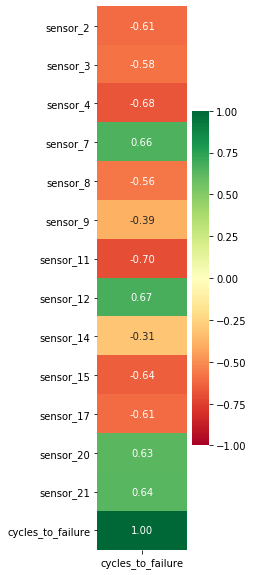

In [26]:
corr_features_target(df_features_scaled, df_cycles_to_failure)

#### 1.5.4.2 Pairwise Correlation

check if features have a pairwise correlation over abs(0.95). If so, drop the feature of the pairs with lower correlation to target

In [27]:
# Check correlation between all features using a heatmap
def pairwise_corr(df_scaled):
    """
    Calcualtes Pearson Correlation between each variable of the dataframe
    
    returns a print out of the correlation as a heatmap
    

    Arguments
    ---------
    df_scaled:  scaled variables as a dataframe 

    """
    # get correlations of each variable in dataset/feature set
    corrMatrix = df_scaled.corr()
    # get index
    top_corr_features = corrMatrix.index

    #plot heat map
    plt.figure(figsize=(20,20))
    # create mask 
    mask = np.triu(df_scaled[top_corr_features].corr())
    # plot heatmap
    ax = sns.heatmap(df_scaled[top_corr_features].corr(),annot=True, vmin=-1, vmax=1, center= 0, mask=mask, fmt='.2f', cmap="RdYlGn")

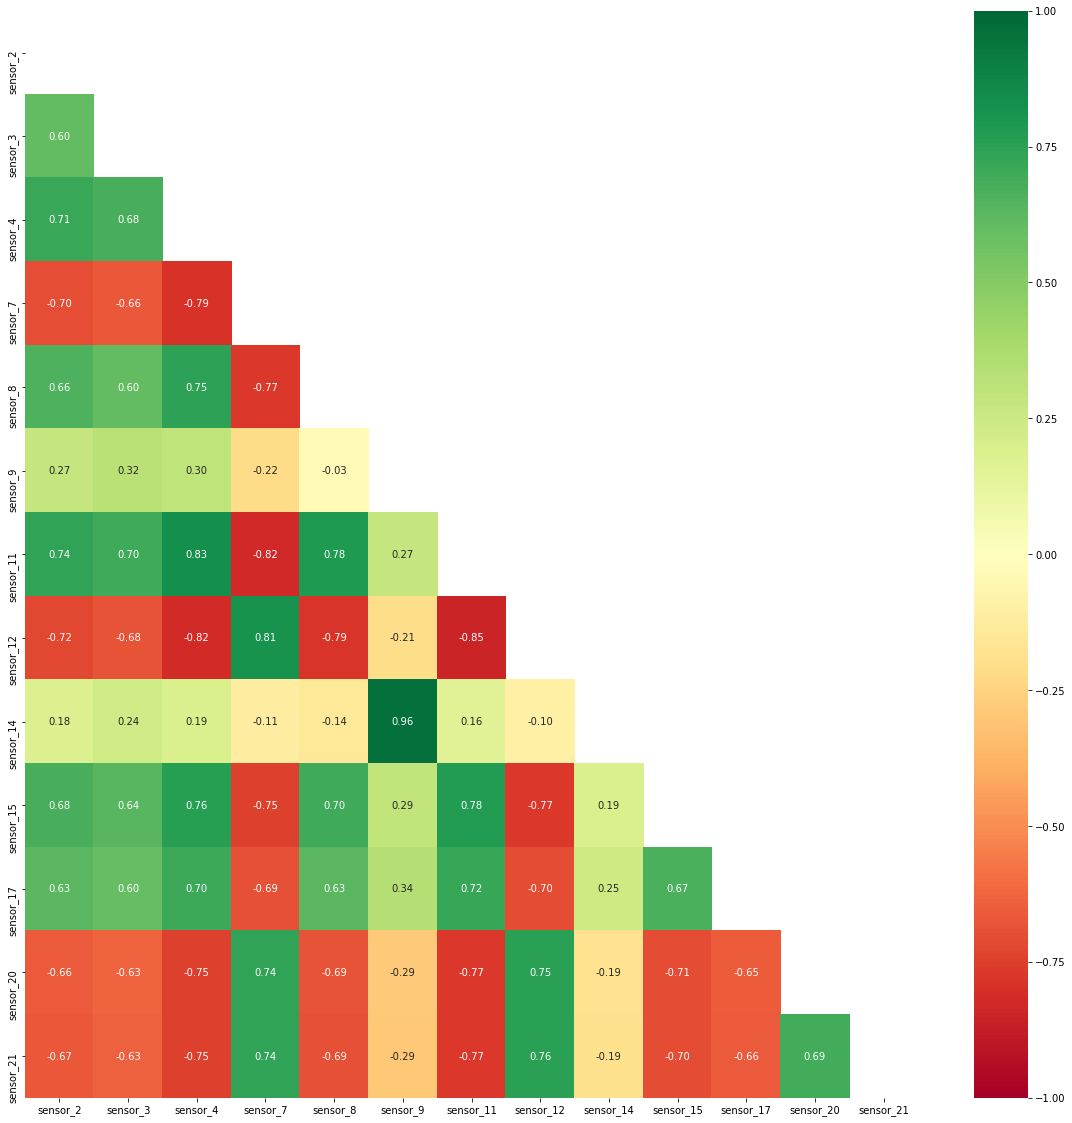

In [28]:
pairwise_corr(df_features_scaled)

since no feature pair has a correlation over abs(0.95), no feature to drop

## 1.6 Feature Reduction using PCA

Since we want to lower complexity of the models and speed up the model training process, we conduct PCA

In [29]:
%%time
from sklearn.decomposition import PCA
# PCA, general exploration of the impact of each component
pca_sensors = PCA()
principalComponents_sensor = pca_sensors.fit(df_features_scaled)

Wall time: 235 ms


In [30]:
# explained_variance_ratio for the amount of variance each principal component holds after reducing the data to a lower dimensional subspace
# output: percentage of total information held by each principal component; 1-(sum of pc) = total lost information
print('Explained variation per principal component: {}'.format(pca_sensors.explained_variance_ratio_))

Explained variation per principal component: [0.63928149 0.1513401  0.03184317 0.02832931 0.02677606 0.02354273
 0.02227753 0.01934911 0.01569906 0.01451269 0.0135338  0.01126006
 0.00225488]


(0, 1)

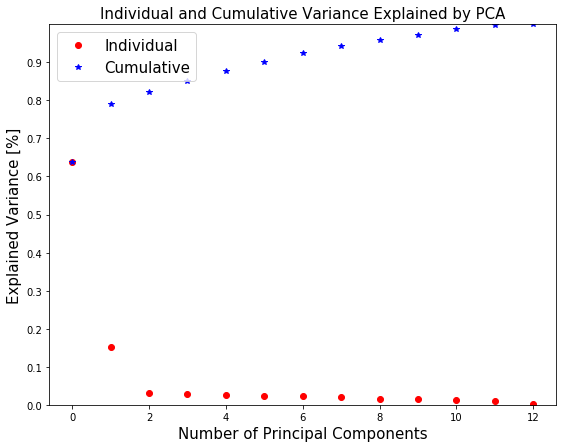

In [31]:
# Visualization of PCA
plt.figure(figsize=(20, 7)) # absolut for the whole figure
# Plot the individual and cumulative variance explained by PCA components
plt.subplot(1,2,1) # subplot 1 of 2
plt.xlabel('Number of Principal Components',fontsize=15)
plt.ylabel('Explained Variance [%]',fontsize=15)
plt.title('Individual and Cumulative Variance Explained by PCA', fontsize=15)
# Individual Variance
ind_var = principalComponents_sensor.explained_variance_ratio_
# Cumulative Variance
cum_var = np.cumsum(principalComponents_sensor.explained_variance_ratio_)
plt.plot(ind_var, 'o', color='red', label='Individual')
plt.plot(cum_var, '*', color='blue', label='Cumulative')
plt.legend(fontsize=15, loc='upper left')
plt.yticks(np.arange(0, 1, step=0.1)) # y-axis ticks
plt.ylim(0,1) # y-axis range

In [32]:
# PCA for limiting to n_components. for demonstation we limit the feature space to 2 components
pca_sensors_2 = PCA(n_components=2)
principalComponents_sensor_2 = pca_sensors_2.fit_transform(df_features_scaled)

In [33]:
# create DataFrame for the principal component values for all samples (n-rows)
df_pc_sensors_2 = pd.DataFrame(data = principalComponents_sensor_2, columns = ['principal_component_1', 'principal_component_2'])

In [34]:
# prepare df for visualization of cycles to failure for pc_1 and pc_2
df_pc_sensors_2_ctf = df_pc_sensors_2.join(df_cycles_to_failure, how='right')
# Add Engine Number to DF
df_pc_sensors_2_ctf = df_pc_sensors_2_ctf.join(dataset['unit'], how='right')
df_pc_sensors_2_ctf.head()

,principal_component_1,principal_component_2,cycles_to_failure,unit
0,-2.784458,-0.453542,192.0,1
1,-2.382082,-0.675610,191.0,1
2,-2.862066,-0.512801,190.0,1
3,-3.491146,-0.576103,189.0,1
4,-2.318093,-0.352755,188.0,1


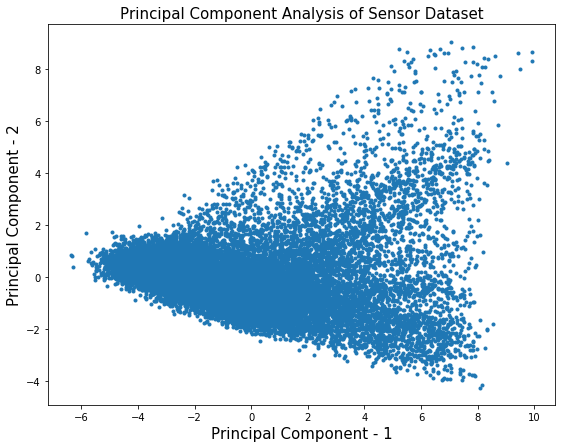

In [35]:
# Visualization of PCA
plt.figure(figsize=(20, 7)) # absolut for the whole figure
# Creating a plot of the first two components
plt.subplot(1,2,1) # subplot 2 of 2
#plt.xticks(fontsize=12)
#plt.yticks(fontsize=14)
plt.xlabel('Principal Component - 1',fontsize=15)
plt.ylabel('Principal Component - 2',fontsize=15)
plt.title("Principal Component Analysis of Sensor Dataset",fontsize=15)
#plt.scatter(df_pc_sensors_2.principal_component_1, df_pc_sensors_2.principal_component_2)
plt.plot(df_pc_sensors_2.principal_component_1, df_pc_sensors_2.principal_component_2, '.')

Check if failure of the 100 machines are similar
-> check if pc1 and pc2 do represent failure time over the 100 machines

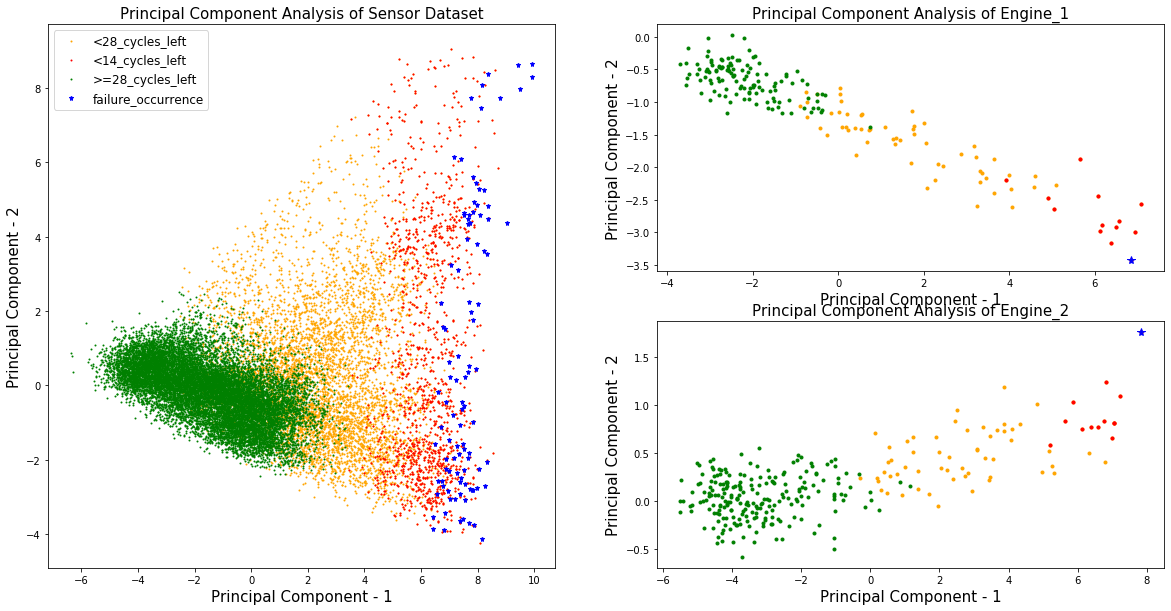

In [36]:
# Visualization of PCA
plt.figure(figsize=(20, 10)) # absolut for the whole figure
# Creating a plot of the first two components
plt.subplot(2,2,(1,3)) # subplot with 2x2 grid, using subplot position 1 and 3
plt.xlabel('Principal Component - 1',fontsize=15)
plt.ylabel('Principal Component - 2',fontsize=15)
plt.title("Principal Component Analysis of Sensor Dataset",fontsize=15)
# Definition of cycles_to_failure clusters
urgent = 14 # less than 14 cycles left to failure
midterm = 70 # less than 50 cycles left to failure
longterm = 70 # more than 50 cycles left to failure
#plt.plot(df_pc_sensors_2.principal_component_1, df_pc_sensors_2.principal_component_2, '.', color='blue') # plot all engine data in blue
plt.plot(df_pc_sensors_2_ctf.principal_component_1.loc[df_pc_sensors_2_ctf['cycles_to_failure']<midterm],
         df_pc_sensors_2_ctf.principal_component_2.loc[df_pc_sensors_2_ctf['cycles_to_failure']<midterm], 'o', color='orange', markersize=1, label='<28_cycles_left') # plot engine data <28 cycles in ornage
plt.plot(df_pc_sensors_2_ctf.principal_component_1.loc[df_pc_sensors_2_ctf['cycles_to_failure']<urgent], 
         df_pc_sensors_2_ctf.principal_component_2.loc[df_pc_sensors_2_ctf['cycles_to_failure']<urgent], 'o', color='red', markersize=1, label='<14_cycles_left') # plot engine data <14 cycles in red
plt.plot(df_pc_sensors_2_ctf.principal_component_1.loc[df_pc_sensors_2_ctf['cycles_to_failure']>=midterm], 
         df_pc_sensors_2_ctf.principal_component_2.loc[df_pc_sensors_2_ctf['cycles_to_failure']>=midterm], 'o', color='green', markersize=1, label='>=28_cycles_left') # plot remaining engine data in green
plt.plot(df_pc_sensors_2_ctf.principal_component_1.loc[df_pc_sensors_2_ctf['cycles_to_failure']==1], 
         df_pc_sensors_2_ctf.principal_component_2.loc[df_pc_sensors_2_ctf['cycles_to_failure']==1], '*', color='blue', markersize=5, label='failure_occurrence') # time of failure in blue
plt.legend(fontsize=12, loc='upper left')

# Visualize pc_1 and pc_2 for 2 specific engines
# engine 1
plt.subplot(2,2,(2)) # subplot with 2x2 grid, using subplot position 2
plt.xlabel('Principal Component - 1',fontsize=15)
plt.ylabel('Principal Component - 2',fontsize=15)
plt.title("Principal Component Analysis of Engine_1",fontsize=15)
unit = 1 # engine 1
plt.plot(df_pc_sensors_2_ctf.principal_component_1.loc[(df_pc_sensors_2_ctf['unit']==unit) & (df_pc_sensors_2_ctf['cycles_to_failure']<midterm)],
         df_pc_sensors_2_ctf.principal_component_2.loc[(df_pc_sensors_2_ctf['unit']==unit) & (df_pc_sensors_2_ctf['cycles_to_failure']<midterm)], 'o', color='orange', markersize=3) # plot engine data <28 cycles in ornage
plt.plot(df_pc_sensors_2_ctf.principal_component_1.loc[(df_pc_sensors_2_ctf['unit']==unit) & (df_pc_sensors_2_ctf['cycles_to_failure']<urgent)], 
         df_pc_sensors_2_ctf.principal_component_2.loc[(df_pc_sensors_2_ctf['unit']==unit) & (df_pc_sensors_2_ctf['cycles_to_failure']<urgent)], 'o', color='red', markersize=3) # plot engine data <14 cycles in red
plt.plot(df_pc_sensors_2_ctf.principal_component_1.loc[(df_pc_sensors_2_ctf['unit']==unit) & (df_pc_sensors_2_ctf['cycles_to_failure']>=midterm)], 
         df_pc_sensors_2_ctf.principal_component_2.loc[(df_pc_sensors_2_ctf['unit']==unit) & (df_pc_sensors_2_ctf['cycles_to_failure']>=midterm)], 'o', color='green', markersize=3) # plot remaining engine data in green
plt.plot(df_pc_sensors_2_ctf.principal_component_1.loc[(df_pc_sensors_2_ctf['unit']==unit) & (df_pc_sensors_2_ctf['cycles_to_failure']==1)], 
         df_pc_sensors_2_ctf.principal_component_2.loc[(df_pc_sensors_2_ctf['unit']==unit) & (df_pc_sensors_2_ctf['cycles_to_failure']==1)], '*', color='blue', markersize=8) # time of failure in blue
# engine 2
plt.subplot(2,2,(4)) # subplot with 2x2 grid, using subplot position 2
plt.xlabel('Principal Component - 1',fontsize=15)
plt.ylabel('Principal Component - 2',fontsize=15)
plt.title("Principal Component Analysis of Engine_2",fontsize=15)
unit = 2 # engine 2
plt.plot(df_pc_sensors_2_ctf.principal_component_1.loc[(df_pc_sensors_2_ctf['unit']==unit) & (df_pc_sensors_2_ctf['cycles_to_failure']<midterm)],
         df_pc_sensors_2_ctf.principal_component_2.loc[(df_pc_sensors_2_ctf['unit']==unit) & (df_pc_sensors_2_ctf['cycles_to_failure']<midterm)], 'o', color='orange', markersize=3) # plot engine data <28 cycles in ornage
plt.plot(df_pc_sensors_2_ctf.principal_component_1.loc[(df_pc_sensors_2_ctf['unit']==unit) & (df_pc_sensors_2_ctf['cycles_to_failure']<urgent)], 
         df_pc_sensors_2_ctf.principal_component_2.loc[(df_pc_sensors_2_ctf['unit']==unit) & (df_pc_sensors_2_ctf['cycles_to_failure']<urgent)], 'o', color='red', markersize=3) # plot engine data <14 cycles in red
plt.plot(df_pc_sensors_2_ctf.principal_component_1.loc[(df_pc_sensors_2_ctf['unit']==unit) & (df_pc_sensors_2_ctf['cycles_to_failure']>=midterm)], 
         df_pc_sensors_2_ctf.principal_component_2.loc[(df_pc_sensors_2_ctf['unit']==unit) & (df_pc_sensors_2_ctf['cycles_to_failure']>=midterm)], 'o', color='green', markersize=3) # plot remaining engine data in green
plt.plot(df_pc_sensors_2_ctf.principal_component_1.loc[(df_pc_sensors_2_ctf['unit']==unit) & (df_pc_sensors_2_ctf['cycles_to_failure']==1)], 
         df_pc_sensors_2_ctf.principal_component_2.loc[(df_pc_sensors_2_ctf['unit']==unit) & (df_pc_sensors_2_ctf['cycles_to_failure']==1)], '*', color='blue', markersize=8) # time of failure in blue


## 1.7 Balance data

Balance data (for proper ml training) by randomly dropping rows from group 1 and 2, so that the number of records for group 1,2 and 3 is equal. Eventhough we lose a lot of valuable data with this simple method, we do save computing time (which we do for demonstration reasons)

In [37]:
# create df for tidy data
df_ctf_tidy = df_ctf
print(df_ctf_tidy.shape[0])
df_ctf_tidy.head(2)

20631


,cycles_to_failure,target
0,192.0,1.0
1,191.0,1.0


In [38]:
# Total number of records in dataset
rec_total = df_ctf_tidy.shape[0]
print('Total number of records: ', rec_total)
# Total number of records for group 1
rec_g1 = df_ctf_tidy.loc[df_ctf_tidy['target'] == 1].shape[0]
print('Total number of records for group 1: ', rec_g1)
# Total number of records for group 2
rec_g2 = df_ctf_tidy.loc[df_ctf_tidy['target'] == 2].shape[0]
print('Total number of records for group 2: ', rec_g2)
# Total number of records for group 3
rec_g3 = df_ctf_tidy.loc[df_ctf_tidy['target'] == 3].shape[0]
print('Total number of records for group 3: ', rec_g3)

Total number of records:  20631
Total number of records for group 1:  13631
Total number of records for group 2:  5700
Total number of records for group 3:  1300


In [39]:
# number of records to drop for class 1 and 2
n_rand_row_1 = rec_g1 - rec_g3
n_rand_row_2 = rec_g2 - rec_g3
print(n_rand_row_1, n_rand_row_2)

12331 4400


In [40]:
# balance data by randomly dropping rows from group 1 and 2, so that the number of records for group 1 ,2 and 3 is equal
indexNames_1 = df_ctf_tidy.query('target == 1').sample(n=n_rand_row_1).index
indexNames_2 = df_ctf_tidy.query('target == 2').sample(n=n_rand_row_2).index
indexNames = np.append(indexNames_1, indexNames_2)
df_ctf_tidy.drop(indexNames, axis=0, inplace=True)
print(df_ctf_tidy.shape[0])

3900


In [41]:
# balance df_pc_sensors_2_ctf
df_pc_sensors_2_ctf_tidy = df_pc_sensors_2_ctf.drop(indexNames, axis=0)
print(df_pc_sensors_2_ctf_tidy.shape[0])

3900


## 1.8 Building a pipeline for data preprocessing

Building a pipeline for the necessary steps which should be applied based on the analysis above.  

The pipeline for preprocessing consists of two steps:  
1. Step: functions to prepare dataframe
2. Step: sklearn.pipeline object for further preprocessing (scaler, PCA)

### 1.8.1 Step: functions to prepare the dataframe

Prepare test and validation data for the model building and evaluation  
- Preperation of training data: apply 'get_features_and_label_from_df' and 'balance_data'
- Preperation of validation data: apply 'get_features_and_label_from_df' only

In [42]:
# function takes a dataframe object as input and does the necessary processing to get features and label as np.array
def get_features_and_label_from_df(df):
    '''
    this function takes a dataframe object as input and does the necessary processing 
    returns features and label as df
    '''
    # get headers
    a_header = ['unit', 'cycle', 'setting_1', 'setting_2', 'setting_3', 'sensor_1', 'sensor_2', 'sensor_3', 'sensor_4', 'sensor_5', 'sensor_6', 'sensor_7', 'sensor_8', 'sensor_9', 'sensor_10', 'sensor_11', 'sensor_12', 'sensor_13', 'sensor_14', 'sensor_15', 'sensor_16', 'sensor_17', 'sensor_18', 'sensor_19', 'sensor_20', 'sensor_21', 'H27', 'H28']
    df.columns = a_header
    # delete unwanted columns 26 and 27
    df = df.drop(['H27', 'H28', 'setting_1', 'setting_2', 'setting_3'], axis=1)
    # delete unwanted features
    df = df.drop(['sensor_1', 'sensor_5', 'sensor_6', 'sensor_10','sensor_13', 'sensor_16', 'sensor_18', 'sensor_19'], axis=1)
    
    # +++ get features +++
    features = df.drop(['unit', 'cycle'], axis=1)
    #features = features.values
    
    # +++ get label +++
    # remaining_cycles_to_failure  
    a_flip_total = np.zeros(0)
    for j in range(100):
        j+=1
        amount_of_cycles_to_failure = df.loc[df['unit'] == j].unit.shape #shape of the dataset for each engine
        amount_of_cycles_to_failure = amount_of_cycles_to_failure[0] # amount of cycles for each engine to failure
        a_flip = np.flip(np.arange(1,amount_of_cycles_to_failure+1)) # flip array for "remaining cycle to failure"
        a_flip_total = np.append(a_flip_total, a_flip) # add value for the next engine
    df_ctf = pd.DataFrame(a_flip_total, columns=['cycles_to_failure'])
    # create labels (urgent, midterm and longterm) for test-dataset
    urgent = 14 # less than 14 cycles left to failure
    midterm = 70 # less than 70 cycles left to failure
    longterm = 70 # more than 70 cycles left to failure
    a_label = np.zeros(0)
    for i, row in df_ctf.iterrows():
        if row['cycles_to_failure'] > longterm:
            label = 1 # longterm
        if row['cycles_to_failure'] <= midterm:
            label = 2 # midterm
        if row['cycles_to_failure'] < urgent:
            label = 3 # urgent
        a_label = np.append(a_label, label)
    label = pd.DataFrame(a_label, columns=['target'])
    if 'target' in df_ctf:
            df_ctf = df_ctf.drop('target', axis=1)
    df_ctf = df_ctf.join(label['target'], how='right')
    # df with target
    #target_clf = df_ctf['target']
    #label = df_ctf['target'].values.ravel() #.ravel() will convert that array shape from (n,1) to (n, )
    label['target'] = df_ctf['target']
    
    return features, label

In [43]:
# function to balance data for training
def balance_data(df_features, df_label):
    '''
    function to balance data for training: equal amount of data for each label
    Input: features, label as df
    returns: balanced features,balanced label as df
    '''
    #df_ctf_tidy = pd.DataFrame(label, columns=['target'])
    df_ctf_tidy = df_label
    # Total number of records in dataset
    rec_total = df_ctf_tidy.shape[0]
    # Total number of records for group 1
    rec_g1 = df_ctf_tidy.loc[df_ctf_tidy['target'] == 1].shape[0]
    # Total number of records for group 2
    rec_g2 = df_ctf_tidy.loc[df_ctf_tidy['target'] == 2].shape[0]
    # Total number of records for group 3
    rec_g3 = df_ctf_tidy.loc[df_ctf_tidy['target'] == 3].shape[0]
    
    # number of records to drop for class 1 and 2
    n_rand_row_1 = rec_g1 - rec_g3
    n_rand_row_2 = rec_g2 - rec_g3
    
    # balance data by randomly dropping rows from group 1 and 2, so that the number of records for group 1 ,2 and 3 is equal
    indexNames_1 = df_ctf_tidy.query('target == 1').sample(n=n_rand_row_1).index
    indexNames_2 = df_ctf_tidy.query('target == 2').sample(n=n_rand_row_2).index
    indexNames = np.append(indexNames_1, indexNames_2)
    df_ctf_tidy.drop(indexNames, axis=0, inplace=True)
    #label_balanced = df_ctf_tidy.values.ravel() #.ravel() will convert that array shape from (n,1) to (n, )
    label_balanced = df_ctf_tidy
    
    # balance features
    df_features = df_features
    df_features.drop(indexNames, axis=0, inplace=True)
    #features_balanced = df_features.values
    features_balanced = df_features
    
    return features_balanced, label_balanced

In [44]:
# training data

# import test dataset
train_data = pd.read_csv('CMAPSSData/train_FD001.txt', header=None, sep=' ')
# apply the fuctions to train data
train_features, train_label = get_features_and_label_from_df(train_data)
X_train, y_train = balance_data(train_features, train_label)

In [45]:
# validation data

# import validation dataset
val_data = pd.read_csv('CMAPSSData/val_FD001.txt', header=None, sep=' ')
# apply the fuctions to validation data
X_val, y_val = get_features_and_label_from_df(val_data)

### 1.8.2 Step: sklearn.pipeline object for further preprocessing (scaler, PCA)

Create data preprocessing part of the pipeline. This will be used and extended with the pipeline part for the classifier and will be applied using GridSearchSV later.

In [46]:
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion

In [47]:
# create feature union
data_preprocessing = FeatureUnion([
    ('scale_data', StandardScaler()),
    ('PCA', PCA(n_components=2))
    ])

# 2. Model Building

- Build, tune (hyperparameter optimization) and evaluate 3 machine learning models (neural network, k-nearest neighbors, support vector machine) to predict the cycles to failure using predefined cycle-clusters (urgent, midterm, longterm).
- Build a pipeline for model building and combine it with the pipeline from data preprocessing
- Comparing the three models

## 2.1 Feature and Labels for Training and Evaluation

For training and optimization we use the features and labels from the pipeline since we already did a train-/validation-split before loading the data.  
This hold out validation split will be used to evaluate the best models for the three different optimized classifiers

## 2.2 Using KNN for Classification

- Build and tune (using grid search for hyperparameter optimization) a KNN classifier
- Evaluate the final classifier on validation set

In [48]:
from matplotlib.colors import ListedColormap
from sklearn.neighbors import NearestNeighbors
from sklearn import neighbors

### 2.2.1 Hyperparameter tuning using GridSearchCV
Using GridSearchCV (Grid Search cross-validation) to find the best number of neighbors and weights (uniform, distance)

In [49]:
#import GridSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

In [50]:
# define grid_searchCV pipeline
pipeline_gsCV_KNN = Pipeline([
    ('data_preprocessing', data_preprocessing),
    ('clf', neighbors.KNeighborsClassifier())
    ])

In [51]:
# get pipeline parameters
pipeline_gsCV_KNN.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'data_preprocessing', 'clf', 'data_preprocessing__n_jobs', 'data_preprocessing__transformer_list', 'data_preprocessing__transformer_weights', 'data_preprocessing__verbose', 'data_preprocessing__scale_data', 'data_preprocessing__PCA', 'data_preprocessing__scale_data__copy', 'data_preprocessing__scale_data__with_mean', 'data_preprocessing__scale_data__with_std', 'data_preprocessing__PCA__copy', 'data_preprocessing__PCA__iterated_power', 'data_preprocessing__PCA__n_components', 'data_preprocessing__PCA__random_state', 'data_preprocessing__PCA__svd_solver', 'data_preprocessing__PCA__tol', 'data_preprocessing__PCA__whiten', 'clf__algorithm', 'clf__leaf_size', 'clf__metric', 'clf__metric_params', 'clf__n_jobs', 'clf__n_neighbors', 'clf__p', 'clf__weights'])

In [52]:
%%time
# evaluate pipeline
kfold = KFold(n_splits=5, shuffle=True, random_state=1)
# for knn: parameter to be tuned: n_neighbors
param_grid = {'clf__n_neighbors':np.arange(1,20),
              'clf__weights':['uniform', 'distance']}
KNN_pipeline_model = GridSearchCV(estimator=pipeline_gsCV_KNN, param_grid=param_grid, cv=kfold, verbose=1)
KNN_pipeline_model.fit(X_train, y_train.values.ravel()) #.ravel() will convert that array shape from (n,1) to (n, )

Fitting 5 folds for each of 38 candidates, totalling 190 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Wall time: 8.61 s


[Parallel(n_jobs=1)]: Done 190 out of 190 | elapsed:    8.5s finished


GridSearchCV(cv=KFold(n_splits=5, random_state=1, shuffle=True),
             error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('data_preprocessing',
                                        FeatureUnion(n_jobs=None,
                                                     transformer_list=[('scale_data',
                                                                        StandardScaler(copy=True,
                                                                                       with_mean=True,
                                                                                       with_std=True)),
                                                                       ('PCA',
                                                                        PCA(copy=True,
                                                                            iterated_power='auto',
                                                                            

In [53]:
# View the accuracy score
print('Best score for training data:', KNN_pipeline_model.best_score_,"\n")
# View the best parameters for the model found using grid search
print('Best parameters for training data:', KNN_pipeline_model.best_params_,"\n")

Best score for training data: 0.8305128205128206 

Best parameters for training data: {'clf__n_neighbors': 19, 'clf__weights': 'distance'} 



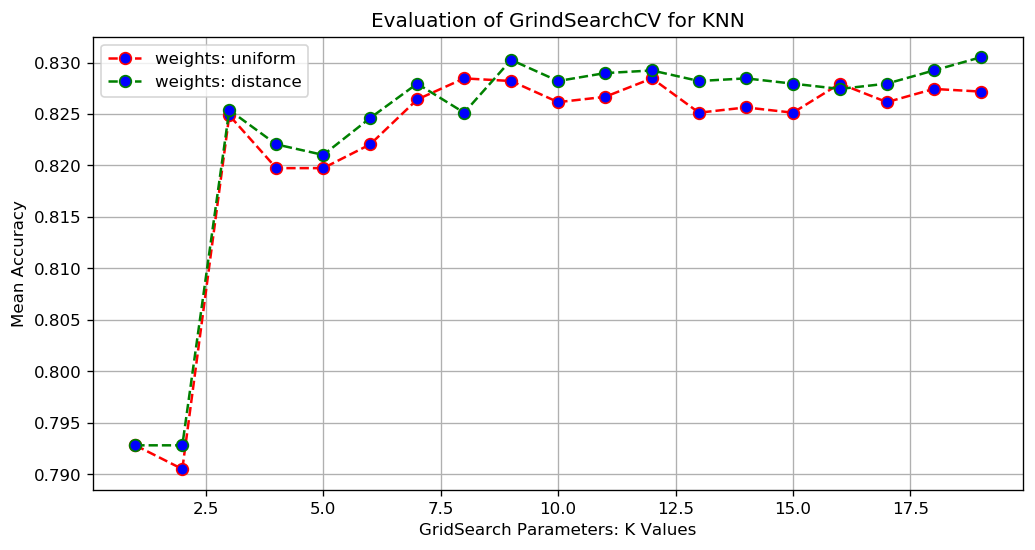

In [54]:
# Visualize GridSearchCV

# all results
#print(KNN_pipeline_model.cv_results_)
# params: parameter settings
gridsearchCV_params = KNN_pipeline_model.cv_results_['params']
# includes the scores
gridsearchCV_scores = KNN_pipeline_model.cv_results_['mean_test_score']

# make df out of dictionary(gridsearchCV_params)
df_gsCV_params = pd.DataFrame(gridsearchCV_params)
# make DataFrame for Score-Array from svm_model_cv_results_
df_gsCV_scores = pd.DataFrame(gridsearchCV_scores)
df_gsCV_scores.columns = ['Score']
# Make 1 DataFrame
df_gsCV = df_gsCV_params.join(df_gsCV_scores, how='right')

# Plot results
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5), dpi=120) # whole figre size
plt.title('Evaluation of GrindSearchCV for KNN')
plt.ylabel('Mean Accuracy')
plt.xlabel('GridSearch Parameters: K Values')
plt.grid()

# Select Data for the Curves
Y_uniform = df_gsCV.Score.loc[(df_gsCV['clf__weights']=='uniform')]
plt.plot(range(1, len(Y_uniform)+1), Y_uniform, marker='o', color='r',linestyle='dashed', markerfacecolor='blue', markersize=7, label='weights: uniform')
Y_distance = df_gsCV.Score.loc[(df_gsCV['clf__weights']=='distance')]
plt.plot(range(1, len(Y_distance)+1), Y_distance, marker='o', color='g',linestyle='dashed', markerfacecolor='blue', markersize=7, label='weights: distance')
plt.xticks()
plt.legend()

### 2.2.2 Evaluation of the final classifier

Evaluation of final KNN model using hold out validation dataset

In [55]:
# get best estimator and make prediction on validation data
final_KNN_model = KNN_pipeline_model.best_estimator_
y_pred = final_KNN_model.predict(X_val)
#y_pred_label = list(encoder.inverse_transform(y_pred))

In [56]:
# import classification_report
from sklearn.metrics import classification_report
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

         1.0       0.95      0.89      0.92      2969
         2.0       0.72      0.77      0.74      1140
         3.0       0.65      1.00      0.79       260

    accuracy                           0.86      4369
   macro avg       0.78      0.88      0.82      4369
weighted avg       0.88      0.86      0.87      4369



In [57]:
# Using sklearn for confusion matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_val, y_pred)

In [58]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions
                  If 'both', plot raw numbers and proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Credits
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    # calculate accucary and misclass
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    # check for color map
    if cmap is None:
        cmap = plt.get_cmap('Blues')

    fig = plt.figure(figsize=(8, 6))
    # set x and y ticks
    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)
    
    # calculate normalized confusion matrix
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
            
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()
    
    # save plot
    name_fig = title + '.png'
    fig.savefig(name_fig, bbox_inches='tight', dpi=fig.dpi)

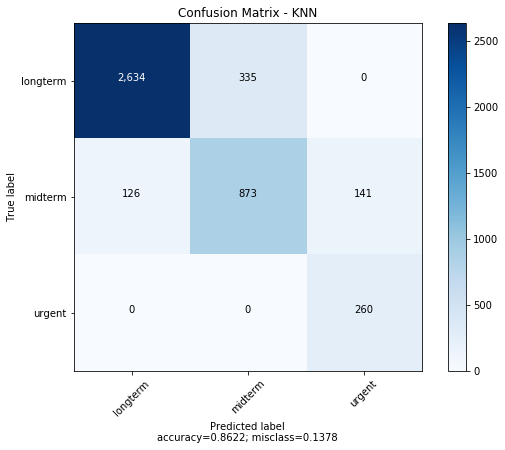

In [59]:
plot_confusion_matrix(cm           = cm,
                      normalize    = False,
                      target_names = ['longterm', 'midterm', 'urgent'],
                      title        = "Confusion Matrix - KNN")

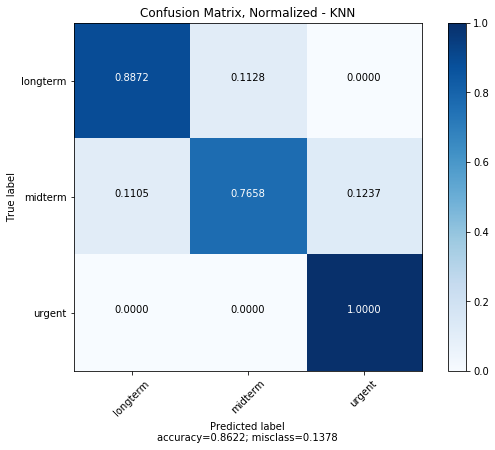

In [60]:
plot_confusion_matrix(cm           = cm, 
                      normalize    = True,
                      target_names = ['longterm', 'midterm', 'urgent'],
                      title        = "Confusion Matrix, Normalized - KNN")

## 2.3 Using SVM for Classification

- Build and tune (using grid search for hyperparameter optimization) a SVM classifier
- Evaluate the final classifier on validation set

### 2.3.1 Hyperparameter tuning using grid search and cross validation

In [61]:
from sklearn.utils import shuffle
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.model_selection import cross_val_score, GridSearchCV
import os

In [62]:
# define grid_searchCV pipeline
pipeline_gsCV_SVM = Pipeline([
    ('data_preprocessing', data_preprocessing),
    ('clf_svm', SVC())
    ])

In [63]:
# get pipeline parameters
pipeline_gsCV_SVM.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'data_preprocessing', 'clf_svm', 'data_preprocessing__n_jobs', 'data_preprocessing__transformer_list', 'data_preprocessing__transformer_weights', 'data_preprocessing__verbose', 'data_preprocessing__scale_data', 'data_preprocessing__PCA', 'data_preprocessing__scale_data__copy', 'data_preprocessing__scale_data__with_mean', 'data_preprocessing__scale_data__with_std', 'data_preprocessing__PCA__copy', 'data_preprocessing__PCA__iterated_power', 'data_preprocessing__PCA__n_components', 'data_preprocessing__PCA__random_state', 'data_preprocessing__PCA__svd_solver', 'data_preprocessing__PCA__tol', 'data_preprocessing__PCA__whiten', 'clf_svm__C', 'clf_svm__break_ties', 'clf_svm__cache_size', 'clf_svm__class_weight', 'clf_svm__coef0', 'clf_svm__decision_function_shape', 'clf_svm__degree', 'clf_svm__gamma', 'clf_svm__kernel', 'clf_svm__max_iter', 'clf_svm__probability', 'clf_svm__random_state', 'clf_svm__shrinking', 'clf_svm__tol', 'clf_svm__verbose'])

In [64]:
%%time
# evaluate pipeline
kfold = KFold(n_splits=5, shuffle=True, random_state=1)
# for SVM: parameter to be tuned:
# gamma default, array for gamma with 3 values
gamma_default = 1/X_train.shape[0]
array_gamma = np.array([gamma_default/10, gamma_default, gamma_default*10])
param_grid = [{'clf_svm__kernel': ['poly'], 'clf_svm__degree': [1,3], 'clf_svm__gamma': array_gamma, 'clf_svm__C': [1, 10]},
             {'clf_svm__kernel': ['rbf'], 'clf_svm__gamma': array_gamma, 'clf_svm__C': [1, 10]}]
SVM_pipeline_model = GridSearchCV(estimator=pipeline_gsCV_SVM, param_grid=param_grid, cv=kfold, verbose=1)
SVM_pipeline_model.fit(X_train, y_train.values.ravel()) #.ravel() will convert that array shape from (n,1) to (n, )

Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:  1.9min finished


Wall time: 1min 55s


GridSearchCV(cv=KFold(n_splits=5, random_state=1, shuffle=True),
             error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('data_preprocessing',
                                        FeatureUnion(n_jobs=None,
                                                     transformer_list=[('scale_data',
                                                                        StandardScaler(copy=True,
                                                                                       with_mean=True,
                                                                                       with_std=True)),
                                                                       ('PCA',
                                                                        PCA(copy=True,
                                                                            iterated_power='auto',
                                                                            

In [65]:
# View the accuracy score
print('Best score for training data:', SVM_pipeline_model.best_score_,"\n")
# View the best parameters for the model found using grid search
print('Best parameters for training data:', SVM_pipeline_model.best_params_,"\n")

Best score for training data: 0.8651282051282052 

Best parameters for training data: {'clf_svm__C': 10, 'clf_svm__gamma': 0.002564102564102564, 'clf_svm__kernel': 'rbf'} 



**Visualization of GridSearchCV for SVM**

plotting the results (accuracy) of all model variations:  
Y-Axis = accuracy / X-Axis = model variations

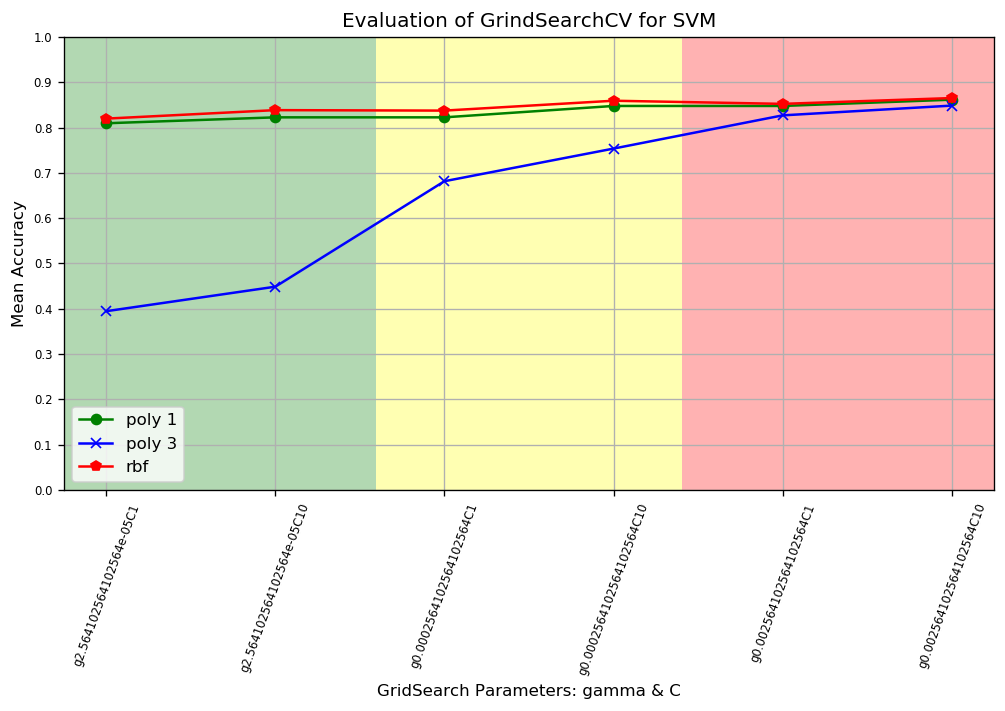

In [66]:
# Visualize GridSearchCV

# all results
#print(KNN_pipeline_model.cv_results_)
# params: parameter settings
gridsearchCV_params = SVM_pipeline_model.cv_results_['params']
# includes the scores
gridsearchCV_scores = SVM_pipeline_model.cv_results_['mean_test_score']

# make df out of dictionary(gridsearchCV_params)
df_gsCV_params = pd.DataFrame(gridsearchCV_params)
# make DataFrame for Score-Array from svm_model_cv_results_
df_gsCV_scores = pd.DataFrame(gridsearchCV_scores)
df_gsCV_scores.columns = ['Score']
# Make 1 DataFrame
df_gsCV = df_gsCV_params.join(df_gsCV_scores, how='right')
# Sort DF so that its in the right order for plotting
df_gsCV = df_gsCV.sort_values(by=['clf_svm__gamma', 'clf_svm__C'])
# define categorical data for x-axis
a_x_axis = np.empty((0))
# iterate dataframe
for index, row in df_gsCV.iterrows():
    # grab value of df.gamma and fd.C and store them in an array
    a_x_axis = np.append(a_x_axis, np.array('g'+ str(df_gsCV.loc[index, 'clf_svm__gamma']) + 'C' + str(df_gsCV.loc[index, 'clf_svm__C'])))
df_gsCV['xaxis'] = a_x_axis


# Plot results
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5), dpi=120) # whole figre size
plt.title('Evaluation of GrindSearchCV for SVM')
plt.ylabel('Mean Accuracy')
plt.xlabel('GridSearch Parameters: gamma & C')
           
# Select Data for the Curves
# Poly 1
X_P1 = df_gsCV.xaxis.loc[(df_gsCV['clf_svm__kernel']=='poly') & (df_gsCV['clf_svm__degree']==1.0)]
Y_P1 = df_gsCV.Score.loc[(df_gsCV['clf_svm__kernel']=='poly') & (df_gsCV['clf_svm__degree']==1.0)]
plt.plot(X_P1, Y_P1, marker='o', color='g', label='poly 1')
# Poly 3
X_P3 = df_gsCV.xaxis.loc[(df_gsCV['clf_svm__kernel']=='poly') & (df_gsCV['clf_svm__degree']==3.0)]
Y_P3 = df_gsCV.Score.loc[(df_gsCV['clf_svm__kernel']=='poly') & (df_gsCV['clf_svm__degree']==3.0)]
plt.plot(X_P3, Y_P3, marker='x', color='b', label='poly 3')
# rbf
X_rbf = df_gsCV.xaxis.loc[(df_gsCV['clf_svm__kernel']=='rbf')]
Y_rbf = df_gsCV.Score.loc[(df_gsCV['clf_svm__kernel']=='rbf')]
plt.plot(X_rbf, Y_rbf, marker='p', color='r', label='rbf')

# optimize plot
plt.xticks(fontsize=7, rotation=70)
plt.yticks(np.arange(0, 1.1, step=0.1), fontsize=7)
plt.legend()
plt.ylim(0, 1)
plt.grid()
# Set background color by using rectangulars. x-numbers by try and error
plt.axhspan(ymin=0, ymax=1, xmin=0, xmax=0.335, facecolor='green', alpha=0.3)
plt.axhspan(ymin=0, ymax=1, xmin=0.335, xmax=0.665, facecolor='yellow', alpha=0.3)
plt.axhspan(ymin=0, ymax=1, xmin=0.665, xmax=1, facecolor='red', alpha=0.3)

### 2.3.2 Evaluation of final SVM classifier

Evaluation of final SVM model using hold out validation dataset

In [67]:
# get best estimator and make prediction on validation data
final_SVM_model = SVM_pipeline_model.best_estimator_
y_pred = final_SVM_model.predict(X_val)
#y_pred_label = list(encoder.inverse_transform(y_pred))

In [68]:
# import classification_report
from sklearn.metrics import classification_report
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

         1.0       0.95      0.90      0.92      2969
         2.0       0.73      0.75      0.74      1140
         3.0       0.65      0.99      0.78       260

    accuracy                           0.86      4369
   macro avg       0.78      0.88      0.82      4369
weighted avg       0.88      0.86      0.87      4369



In [69]:
# Using sklearn for confusion matrix
from sklearn.metrics import confusion_matrix
cm_svm = confusion_matrix(y_val, y_pred)

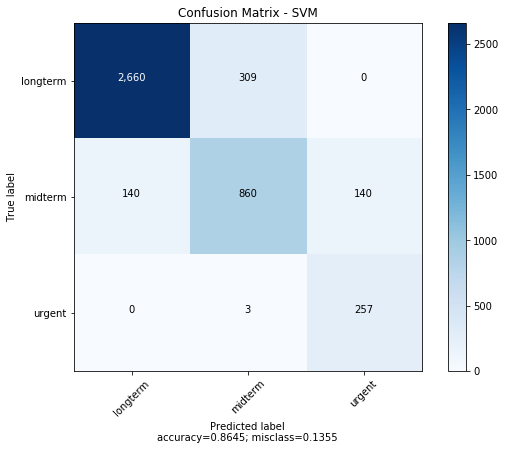

In [70]:
plot_confusion_matrix(cm           = cm_svm,
                      normalize    = False,
                      target_names = ['longterm', 'midterm', 'urgent'],
                      title        = "Confusion Matrix - SVM")

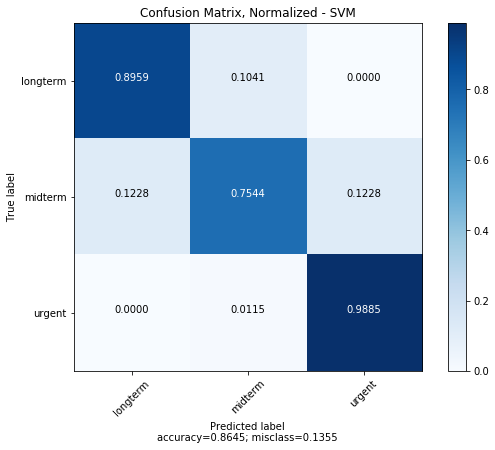

In [71]:
plot_confusion_matrix(cm           = cm_svm,
                      normalize    = True,
                      target_names = ['longterm', 'midterm', 'urgent'],
                      title        = "Confusion Matrix, Normalized - SVM")

## 2.4 Using a Neural Network for Classification

- Build and tune (using random search for hyperparameter optimization including neural network architecture) a NN classifier
- Evaluate the final classifier on validation set
- Visualize the final classifier

In [72]:
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils

from sklearn.preprocessing import LabelEncoder

Using TensorFlow backend.


In [73]:
import kerastuner
from kerastuner.tuners import RandomSearch
from kerastuner.engine.hyperparameters import HyperParameters
kerastuner.__version__

'1.0.1'

### 2.4.1 Data preprocessing for NN classifier
Since we need to do label encoding for NN and this cannot be integrated in sklearn pipelines (only applies for features) we build a custom pipeline:
- fit and transform on test data
- transform on val data

In [74]:
from sklearn.preprocessing import OneHotEncoder

In [75]:
# Pipeline test data

# import test dataset
train_data = pd.read_csv('CMAPSSData/train_FD001.txt', header=None, sep=' ')
# apply functions for data preprocessing
train_features, train_label = get_features_and_label_from_df(train_data)
X_train, y_train = balance_data(train_features, train_label)
# Standardiztation of data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
# PCA
pca_sensors_2 = PCA(n_components=2)
X_train_pca = pca_sensors_2.fit_transform(X_train_scaled)
X_train_pca = np.array(X_train_pca)
# OneHotEncoder for NN, encode class values as integers
encoder = OneHotEncoder()
encoder.fit(y_train)
y_train_dummy = encoder.transform(y_train).toarray()
y_train_dummy = np.array(y_train_dummy)

In [76]:
# Pipeline validation data

# import validation dataset
val_data = pd.read_csv('CMAPSSData/test_FD001.txt', header=None, sep=' ')
# apply function for data preprocessing
X_val, y_val = get_features_and_label_from_df(val_data)
# scaling valdiation data
X_val_scaled = scaler.transform(X_val)
# pca validation data
X_val_pca = pca_sensors_2.transform(X_val_scaled)
X_val_pca = np.array(X_val_pca)
# OneHotEncoder for NN, encode class values as integers
y_val_dummy = encoder.transform(y_val).toarray()
y_val_dummy = np.array(y_val_dummy)

### 2.4.2 Finding proper NN with hyperparameter tuning using random search

#### 2.4.2.1 Finding the best NN architecture and model hyperparameters

Conducting an optimization (random search with 100 model variations) to find best hyperparameters for the give problem. Number of epochs=10 and batch_size=5 is fixed and generalization/overfitting will be evaluated in a sequential step.

Parameter space:  
- number of hidden layers: [min_value=1, max_value=6, step=1]
- number of neurons in each single hidden layer: [min_value=2, max_value=14, step=4]
- drop out rate of hidden layers: [0.0, 0.2]
- optimizer: ['adam', 'sgd']
- activation function: ['relu', 'sigmoid']

In [77]:
def tune_optimizer_model(hp):
    
    """
    visualize results for a specific nn classifier

    Arguments
    ---------
    hp:            feature dataset as np.array
    y:            target dataset as np.array
    nn_model:     tf/keras model of a neural network
    
    """
    
    # HYPERPARAMETER: number of layers, +++integrated in loop+++
    #hp.Int('num_layers', min_value=1, max_value=5, step=1)
    
    # HYPERPARAMETER: number of neurons, +++integrated in loop+++
    #units = hp.Int('units', min_value=4, max_value=16, step=4)
    
    # HYPERPARAMETER: optimizer
    #optimizer = hp.Choice('optimizer', ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam'])
    #optimizer = hp.Choice('optimizer', [Adam(learning_rate=learning_rate), SGD(learning_rate=learning_rate, momentum=momentum)])
    optimizer = hp.Choice('optimizer', ['adam', 'sgd'])
    
    # Hyperparameter: learning_rate
    #learning_rate = hp.Choice('learning_rate', [0.05, 0.1, 0.15, 0.2, 0.25])
    
    # Hyperparameter: momentum
    #momentum = hp.Choice('momentum', [0.5, 0.9, 0.99])
    
    # Hyperparameter: activation function
    #activation = hp.Choice('activation', ['softmax', 'softplus', 'softsign', 'relu', 'tanh', 'sigmoid', 'hard_sigmoid', 'linear'])
    activation = hp.Choice('activation', ['relu', 'sigmoid'])
    
    # Hyperparameter: drop out rate, +++integrated in loop+++
    #drop_rate = hp.Choice('drop_rate', [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])
    
   
    # create model
    model = keras.Sequential()
     
    # HYPERPARAMETER: searcher for best number of layers between min_value and max_value with stepsize of step
    # LOOP NOTE: loop includes min_value and max_value (refers to hp.Int(...)), but i allways starts from 0 and goes to max_value-1
    for i in range(hp.Int('num_inner_layers', min_value=1, max_value=6, step=1)):
        # HYPERPARAMETER: Number of neurons in each layer
        units = hp.Int('units_in_layer_' + str(i+1), min_value=2, max_value=14, step=4) # +1 since its for the unique name of the i-th layer but i start with 0
        # defines input layer and searches(optimizes) for number of neurons for first layer
        if i == 0:
            model.add(keras.layers.Dense(units=units,
                                         activation=activation,
                                         input_shape=[X_train_pca.shape[1]]))
                                         # NOTE: INPUT_SHAPE NEEDS TO BE ADAPTED
        # define all but not first layer
        else:
            model.add(keras.layers.Dense(units=units,
                                         activation=activation))
        # HYPERPARAMETER: drop out rate for each layer
        drop_rate = hp.Choice('drop_rate_in_layer_' + str(i+1), [0.0, 0.2]) # +1 since its for the unique name of the i-th layer but i start with 0
        model.add(keras.layers.Dropout(rate=drop_rate))
    # define outputlayer
    model.add(keras.layers.Dense(3, activation='softmax')) # softmax for final prediction
    
    # Compile model
    model.compile(optimizer=optimizer,
                  loss = 'categorical_crossentropy',
                  metrics = ['accuracy'])
   
    return model

In [78]:
# create and configure tuner

# Directory to save logs
import time
LOG_DIR = 'log_keras-tuner_' + f"{int(time.time())}"

# random seed
random_seed = 1

# define the tuner
tuner = RandomSearch(
            tune_optimizer_model,
            objective='val_accuracy',
            # number of modelvariations to test
            max_trials=100,
            # how many trials per model variation (same model could perform differently)
            executions_per_trial=1,
            directory=LOG_DIR,
            #project_name='tune_optimizer',
            seed=random_seed
            )

In [79]:
# get a summary of the different parameter values from our Tuner, NOTE: only gives back the summary for the NN with min number of layers!
search_space_summary = tuner.search_space_summary()
search_space_summary

In [80]:
%%time
# start the optimization
tuner.search(x=X_train_pca,
             y=y_train_dummy,
             epochs=10,
             batch_size=5,
             validation_data=(X_val_pca, y_val_dummy),
             verbose=0
             )

INFO:tensorflow:Oracle triggered exit
Wall time: 55min 10s


In [81]:
# gives back the best parameters for HP searchspace, NOTE: this is not the best model (e.g. gives back best HPs for layer 6 but best model may only has 4 layers)
best_hyperparameters = tuner.get_best_hyperparameters()[0].values
best_hyperparameters

{'optimizer': 'sgd',
 'activation': 'relu',
 'num_inner_layers': 6,
 'units_in_layer_1': 2,
 'drop_rate_in_layer_1': 0.2,
 'units_in_layer_2': 10,
 'drop_rate_in_layer_2': 0.0,
 'units_in_layer_3': 10,
 'drop_rate_in_layer_3': 0.0,
 'units_in_layer_4': 10,
 'drop_rate_in_layer_4': 0.2,
 'units_in_layer_5': 10,
 'drop_rate_in_layer_5': 0.2,
 'units_in_layer_6': 6,
 'drop_rate_in_layer_6': 0.2}

In [82]:
# gives back NN architecture for best model, NOTE: layer terms/names do not match with layer terms/names of Keras Tuner
best_model = tuner.get_best_models()[0]
best_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 2)                 6         
_________________________________________________________________
dropout (Dropout)            (None, 2)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                30        
_________________________________________________________________
dropout_1 (Dropout)          (None, 10)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                110       
_________________________________________________________________
dropout_2 (Dropout)          (None, 10)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 10)                1

#### 2.4.2.2 Finding best training hyperparameters (epochs, batchsize)
- check epochs for best model to taggle overfitting/gerneralization
- keep batchsize the same for simplicity reasons

In [83]:
from keras.models import Sequential
from keras.layers import Dense, Dropout

In [84]:
# rebuild best model
def baseline_model():
    # create model
    model = Sequential()
    model.add(Dense(2, input_dim=2, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(10, activation='relu'))
    model.add(Dense(10, activation='relu'))
    model.add(Dense(10, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(10, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(6, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(3, activation='softmax'))
    # Compile model
    model.compile(optimizer='sgd',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

In [85]:
%%time
# retrain model to inspect overfitting
final_NN_model = baseline_model()
history = final_NN_model.fit(X_train_pca, y_train_dummy, validation_data=(X_val_pca, y_val_dummy), epochs=50, batch_size=5, verbose=0)

Wall time: 2min 20s


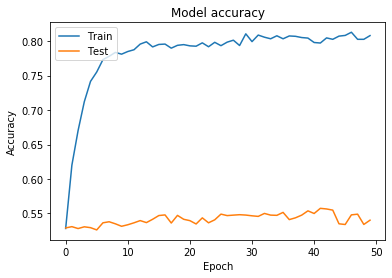

In [86]:
# Plot training & validation accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

### 2.4.3 Evaluation of final NN classifier

Evaluation of final NN model using hold out validation dataset

In [87]:
%%time
# train final NN model
final_NN_model = baseline_model()
final_NN_model.fit(X_train_pca, y_train_dummy, validation_data=(X_val_pca, y_val_dummy), epochs=20, batch_size=5, verbose=0)

Wall time: 51.8 s


In [88]:
from sklearn.metrics import classification_report, confusion_matrix
#from numpy import argmax
# make prediction
y_pred = final_NN_model.predict(X_val_pca)
# round predictions 
y_pred_rounded = np.round(y_pred, 0) # 0 Nachkommastellen
# reverse encoder transformation to get right format for confusion_matrix function
y_pred_rounded_eva = np.argmax(y_pred_rounded, axis=1)
y_test = np.argmax(y_val_dummy, axis=1)
# confucision matrix
c_matrix = confusion_matrix(y_test,y_pred_rounded_eva)
# classification report
clf_report = classification_report(y_test,y_pred_rounded_eva)

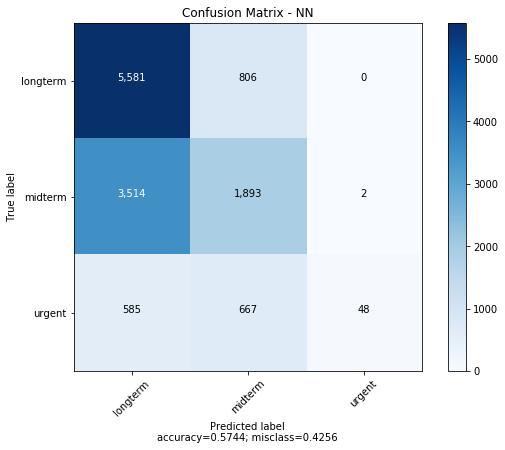

In [89]:
plot_confusion_matrix(cm           = c_matrix,
                      normalize    = False,
                      target_names = ['longterm', 'midterm', 'urgent'],
                      title        = "Confusion Matrix - NN")

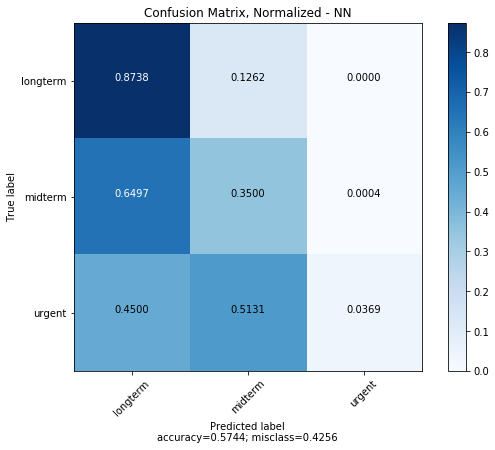

In [90]:
plot_confusion_matrix(cm           = c_matrix,
                      normalize    = True,
                      target_names = ['longterm', 'midterm', 'urgent'],
                      title        = "Confusion Matrix, Normalized - NN")

### 2.4.4 Visualize final NN classifier

Visualization of one of the classifiers (NN classifier) to check how model classifies training and validation data

In [91]:
# function to visualize NN classifier
def classifier_model_with_plot(X, y,
                               model,
                               title='Visualization of Classifier'):
      
    """
    visualize results for a specific nn classifier
    

    Arguments
    ---------
    X:            feature dataset as np.array
    y:            target dataset as np.array
    nn_model:     tf/keras model of a neural network
    
    """
    
    import numpy as np
    import matplotlib.pyplot as plt
    from keras.models import Sequential
    from keras.layers import Dense
    from keras.wrappers.scikit_learn import KerasClassifier
    
    fig, ax1 = plt.subplots(ncols=1, figsize=(10,5))
    
    ax = ax1
    h = .02  # step size in the mesh

    # min and max values from x and build a matrix with all coordinates with distance h
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    
    # prediction for all coordiantes
    Z = model.predict_classes(np.c_[xx.ravel(), yy.ravel()])

    # color background for all points of xx,yy
    Z = Z.reshape(xx.shape)
    ax.contourf(xx, yy, Z, cmap=plt.cm.summer)

    # plot predictions
    ax.scatter(X[:, 0], 
               X[:, 1], 
               c=y, cmap=plt.cm.summer, 
               edgecolors='black')
    ax.get_xaxis()
    ax.get_yaxis()
    
    ax1.set(title = title)

    #plt.show()
    
    return ()

Wall time: 4.75 s


()

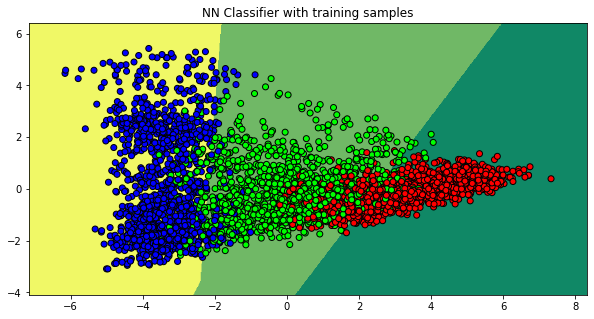

In [92]:
%%time
# visualize NN classifier with training samples
classifier_model_with_plot(X_train_pca, y_train_dummy, model=final_NN_model, title='NN Classifier with training samples')

Wall time: 2.6 s


()

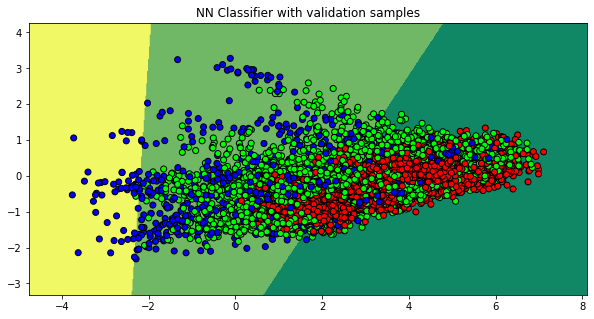

In [93]:
%%time
# visualize NN classifier with validation samples
#nn_with_plot(X_train, y_train, nn_model=best_model)
classifier_model_with_plot(X_val_pca, y_val_dummy, model=final_NN_model, title='NN Classifier with validation samples')

**NOTE:** As we can see from the visualization there is an alarming difference between the distribution of the training and validation data set (eventhough they should be from the same distribution). This leads to a poor classification. Further investigation about this issue has to be done to validate a statistical classifier, I will ignore this for demonstration reasons.

## 2.5 Comparison of the different models

### 2.5.1 Comparison: Accuracy and Confusion Matrix

<table><tr>
<td> <img src="Confusion Matrix - KNN.png" alt="Drawing" style="width: 300px;"/> </td>
<td> <img src="Confusion Matrix - SVM.png" alt="Drawing" style="width: 300px;"/> </td>
<td> <img src="Confusion Matrix - NN.png" alt="Drawing" style="width: 300px;"/> </td>
</tr></table>

<table><tr>
<td> <img src="Confusion Matrix, Normalized - KNN.png" alt="Drawing" style="width: 300px;"/> </td>
<td> <img src="Confusion Matrix, Normalized - SVM.png" alt="Drawing" style="width: 300px;"/> </td>
<td> <img src="Confusion Matrix, Normalized - NN.png" alt="Drawing" style="width: 300px;"/> </td>
</tr></table>